In [262]:
import random
import os
import glob
import json
import csv
import time
import shutil
import math
import json
from itertools import combinations, product, islice

import pandas as pd
import numpy as np
from multiprocessing import Pool, Lock, cpu_count
from concurrent.futures import ThreadPoolExecutor
from scipy import stats

In [2]:
# configure path to the data
current_path = os.path.dirname(os.path.abspath("__file__"))
data_path = os.path.join(current_path, "..", "data")
data_path = os.path.normpath(data_path)
print(data_path)

/home/dk/Desktop/space_weather_econ/data


In [280]:
# read the business and economic data at zcta and state levels
data_zcta_path = os.path.join(data_path, "NAICS_EST_GDP2022_ZCTA.csv")
population_df_path = os.path.join(data_path, "2020_decennial_census_at_ZCTA_level.csv")

# Reading data
data_zcta = pd.read_csv(data_zcta_path)
population_df = pd.read_csv(population_df_path)

# Merging and aggregating data
unique_zcta_regions = data_zcta[['ZCTA', 'REGIONS', "STABBR"]].drop_duplicates()
regions_pop_df = unique_zcta_regions.merge(population_df, on=["ZCTA", "STABBR"])
total_pop_regions = regions_pop_df.groupby("REGIONS")['POP20'].sum().reset_index()

total_pop_regions

,REGIONS,POP20
0,CAISO,36669676
1,ERCOT,25756383
2,FRCC,20269759
3,ISONE,14160438
4,MISO,44656227
5,NYISO,21994860
6,NorthernGridConnected,16095613
7,NorthernGridUnconnected,4593872
8,NotOrder1000,2506448
9,PJM,65742117


### Business Count at the Regions and their Estimated GDP
In our calculation, we assume uniform every person/business contribute equally to State GDP.

In [281]:
# zcta
df_business = (
    data_zcta.groupby(["REGIONS", "NAICS"])[["EST", "GDP2022"]].sum().reset_index()
)

df_business["DailyGDP"] = df_business.GDP2022.map(lambda x: x * 1 / 365)
# print(df_business.GDPREGION.sum())

df_business.head(5)

,REGIONS,NAICS,EST,GDP2022,DailyGDP
0,CAISO,11,1254.0,39439.82,108.054301
1,CAISO,21,257.0,11345.56,31.083726
2,CAISO,22,552.0,50757.63,139.062000
3,CAISO,23,75608.0,131644.55,360.670000
4,CAISO,31,33696.0,380643.36,1042.858521


In [282]:
# caiso
df_business[df_business.REGIONS == "CAISO"]

,REGIONS,NAICS,EST,GDP2022,DailyGDP
0,CAISO,11,1254.0,39439.82,108.054301
1,CAISO,21,257.0,11345.56,31.083726
2,CAISO,22,552.0,50757.63,139.062000
3,CAISO,23,75608.0,131644.55,360.670000
4,CAISO,31,33696.0,380643.36,1042.858521
5,CAISO,42,53245.0,193377.62,529.801699
6,CAISO,44,97324.0,205067.09,561.827644
7,CAISO,48,30875.0,113462.79,310.856959
8,CAISO,51,26753.0,373781.71,1024.059479
9,CAISO,52,47462.0,170451.66,466.990849


In [283]:
# Export the business data as a dictionary
nested_dict = {}
region_pop = total_pop_regions.set_index("REGIONS")["POP20"]

for _, row in df_business.iterrows():
    region = row["REGIONS"]
    naics = row['NAICS']

    if region not in nested_dict:
        nested_dict[region] = {"NAICS": {}, "POP20": region_pop[region]}

    nested_dict[region]["NAICS"][naics] = {'EST': row['EST'], 'DAILYGDP': row['DailyGDP']}


## Estimates of the number of businesses and population without power

In [284]:
# Regions and their possible states (0 or 1)
# states denote all regions with or without power
regions = df_business.REGIONS.unique()

# 0 with power in the entire block, 1 without power
states = [0, 1]

# Generate all possible combinations
combinations = list(product(states, repeat=len(regions)))

df_combinations = pd.DataFrame(combinations, columns=list(df_business.REGIONS.unique()))
df_combinations

,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,NotOrder1000,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32763,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
32764,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
32765,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
32766,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0


In [236]:
df_bus_sum = df_business.groupby("REGIONS")[["EST", "DailyGDP"]].sum().reset_index()
df_bus_po = df_bus_sum.merge(total_pop_regions, on="REGIONS")

df_index = df_bus_po.set_index("REGIONS")

In [238]:
df_index

,EST,DailyGDP,POP20
REGIONS,,,
CAISO,930258.0,8620.352685,36669676
ERCOT,571392.0,5467.883397,25756383
FRCC,584768.0,3453.930137,20269759
ISONE,366368.0,3106.251945,14160438
MISO,1051459.0,7836.202164,44656227
NYISO,585979.0,5617.151589,21994860
NorthernGridConnected,463372.0,3377.839753,16095613
NorthernGridUnconnected,111456.0,829.142932,4593872
NotOrder1000,50756.0,423.807370,2506448


In [239]:
# transpose the business df and cast on the combinatioons df

transposed_df = df_index.T
transposed_df

REGIONS,CAISO,ERCOT,FRCC,ISONE,MISO,NYISO,NorthernGridConnected,NorthernGridUnconnected,NotOrder1000,PJM,SCRTP,SERTP,SPP,WestConnect,WestConnectNonEnrolled
EST,9.302580e+05,5.713920e+05,5.847680e+05,3.663680e+05,1.051459e+06,5.859790e+05,4.633720e+05,1.114560e+05,5.075600e+04,1.550176e+06,6.614400e+04,8.915730e+05,3.596550e+05,2.398830e+05,1.647360e+05
DailyGDP,8.620353e+03,5.467883e+03,3.453930e+03,3.106252e+03,7.836202e+03,5.617152e+03,3.377840e+03,8.291429e+02,4.238074e+02,1.255170e+04,4.032085e+02,6.530127e+03,2.637871e+03,1.708185e+03,1.188548e+03
POP20,3.666968e+07,2.575638e+07,2.026976e+07,1.416044e+07,4.465623e+07,2.199486e+07,1.609561e+07,4.593872e+06,2.506448e+06,6.574212e+07,2.695532e+06,3.995916e+07,1.434230e+07,9.947333e+06,6.191785e+06


The business dataframe consist of total number of the employed, establishments, and population in grid regions

In [240]:
# broadcast the emp, population, and establishment on the combination df

array_transposed = transposed_df.to_numpy()
array_comb = df_combinations.to_numpy()

result_array = array_transposed[:, np.newaxis, :] * array_comb

In [241]:
# store employment, establishments, pop, and daily GDP
indices = list(transposed_df.index)

for i, indx in enumerate(indices):
    print(indx)
    # create dataframes dynamically
    globals()[f"df_{indx}"] = pd.DataFrame(result_array[i], columns=list(regions))

# establishment without power
df_EST["ESTAgg"] = df_EST.sum(axis=1)

# Aggregate of the daily GDP shock
df_DailyGDP["DailyGDPAgg"] = df_DailyGDP.sum(axis=1)

# Population affected
df_POP20["POP20Agg"] = df_POP20.sum(axis=1)

EST
DailyGDP
POP20


3993987.5

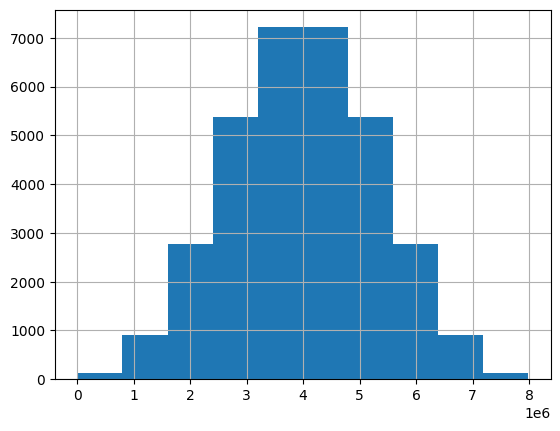

In [243]:
# Est without power
df_EST["ESTAgg"].hist()

df_EST.ESTAgg.quantile(0.5)

31876.098493150683

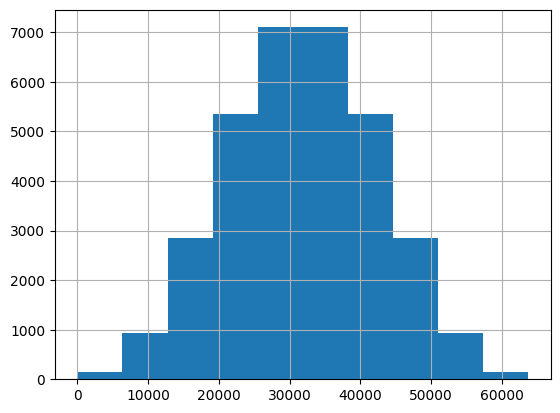

In [244]:
# Aggregate of daily GDP without power
df_DailyGDP["DailyGDPAgg"].hist()
df_DailyGDP["DailyGDPAgg"].quantile(0.5)

### Extract Indices, Rows, and Sum Total of the Percentiles

In [275]:
percentiles = np.linspace(0, 100, 11)

def get_percentiles(df, column):
    # calculate the percentile values
    percentile_values = np.percentile(df[column], percentiles)

    # function to find the closest value in an array
    def find_closest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    # Find the closest values in the dataframe for each percentile
    closest_values = [
        find_closest(df[column], pv) for pv in percentile_values
    ]

    # Extract the rows that have these closest values
    extracted_rows = df[df[column].isin(closest_values)].sort_values(
        by=column
    )
    
    return extracted_rows

In [276]:
data_agg = "POP20Agg"

pop_perc = get_percentiles(df_POP20, data_agg)
pop_perc = pop_perc.T
pop_perc.columns = column_names
pop_perc.drop(data_agg, inplace=True)

pop_perc.head(5)

,perc0,perc10,perc20,perc30,perc40,perc50,perc60,perc70,perc80,perc90,perc100
CAISO,0.0,0.0,0.0,36669676.0,36669676.0,0.0,0.0,0.0,36669676.0,36669676.0,36669676.0
ERCOT,0.0,0.0,25756383.0,0.0,0.0,0.0,25756383.0,25756383.0,0.0,25756383.0,25756383.0
FRCC,0.0,0.0,0.0,20269759.0,0.0,20269759.0,20269759.0,0.0,20269759.0,20269759.0,20269759.0
ISONE,0.0,14160438.0,0.0,14160438.0,0.0,0.0,14160438.0,0.0,14160438.0,0.0,14160438.0
MISO,0.0,44656227.0,0.0,44656227.0,44656227.0,0.0,0.0,0.0,44656227.0,0.0,44656227.0


In [277]:
# Generate column names based on percentiles for the number of establishments
column_names = [f"perc{int(i)}" if i != 0 else 'perc0' for i in percentiles]
data_type = "EST"
data_agg = "ESTAgg"
df = df_EST

# Calculate establishments percentiles and transform
est_percentiles = get_percentiles(df, data_agg)
est_perc_transformed = est_percentiles.T
est_perc_transformed.columns = column_names
est_perc_transformed.drop(data_agg, inplace=True)

# Create new rows classified by NAICS codes using nested_dict
new_rows = []
new_col_names = ["REGIONS", "NAICS"]

for reg, row in est_perc_transformed.iterrows():
    non_zero_indices = [i for i, value in enumerate(row) if value != 0]

    for naics, data in nested_dict[reg]["NAICS"].items():
        new_row = [reg, naics] + [data[data_type] if i in non_zero_indices else 0 for i in range(len(row))]
        new_rows.append(new_row)

# Creating the final DataFrame
new_col_names.extend(column_names)
naics_perc_df_est = pd.DataFrame(new_rows, columns=new_col_names)
naics_perc_df_est.head(5)

,REGIONS,NAICS,perc0,perc10,perc20,perc30,perc40,perc50,perc60,perc70,perc80,perc90,perc100
0,CAISO,11,0,0.0,0.0,1254.0,0.0,0.0,1254.0,0.0,1254.0,1254.0,1254.0
1,CAISO,21,0,0.0,0.0,257.0,0.0,0.0,257.0,0.0,257.0,257.0,257.0
2,CAISO,22,0,0.0,0.0,552.0,0.0,0.0,552.0,0.0,552.0,552.0,552.0
3,CAISO,23,0,0.0,0.0,75608.0,0.0,0.0,75608.0,0.0,75608.0,75608.0,75608.0
4,CAISO,31,0,0.0,0.0,33696.0,0.0,0.0,33696.0,0.0,33696.0,33696.0,33696.0


In [278]:
# Generate column names based on percentiles for daily GDP
column_names = [f"perc{int(i)}" if i != 0 else 'perc0' for i in percentiles]
data_type = "DAILYGDP"
data_agg = "DailyGDPAgg"
df = df_DailyGDP

# Calculate daily GDP percentiles and transform
daily_gdp_perc = get_percentiles(df, data_agg)
daily_gdp_perc_t = daily_gdp_perc.T
daily_gdp_perc_t.columns = column_names
daily_gdp_perc_t.drop(data_agg, inplace=True)

# Create new rows classified by NAICS codes using nested_dict
new_rows = []
new_col_names = ["REGIONS", "NAICS"]

for reg, row in daily_gdp_perc_t.iterrows():
    non_zero_indices = [i for i, value in enumerate(row) if value != 0]

    for naics, data in nested_dict[reg]["NAICS"].items():
        new_row = [reg, naics] + [data[data_type] if i in non_zero_indices else 0 for i in range(len(row))]
        new_rows.append(new_row)

# Creating the final DataFrame
new_col_names.extend(column_names)
naics_perc_df_gdp = pd.DataFrame(new_rows, columns=new_col_names)
naics_perc_df_gdp.head(5)

,REGIONS,NAICS,perc0,perc10,perc20,perc30,perc40,perc50,perc60,perc70,perc80,perc90,perc100
0,CAISO,11,0,108.054301,0.0,0.0,0.0,108.054301,108.054301,108.054301,108.054301,0.0,108.054301
1,CAISO,21,0,31.083726,0.0,0.0,0.0,31.083726,31.083726,31.083726,31.083726,0.0,31.083726
2,CAISO,22,0,139.062000,0.0,0.0,0.0,139.062000,139.062000,139.062000,139.062000,0.0,139.062000
3,CAISO,23,0,360.670000,0.0,0.0,0.0,360.670000,360.670000,360.670000,360.670000,0.0,360.670000
4,CAISO,31,0,1042.858521,0.0,0.0,0.0,1042.858521,1042.858521,1042.858521,1042.858521,0.0,1042.858521


In [279]:
# combine dataframes and export to JSON file
data = {
    "POPULATION": pop_perc.to_dict(),
    "ESTB": est_perc_transformed.to_dict(),
    "ESTBNAICS": naics_perc_df_est.to_dict(),
    "DailyGDP": est_perc_transformed.to_dict(),
    "DailyGDPNAICS": naics_perc_df_gdp.to_dict()
}

# save the dfs
file_path = os.path.join(data_path, 'data.json')

# Writing dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

### Loss Estimation by Randomly Assigning Percentage of Businesses and Population without Power

In [6]:
# simplifiied code for GDP Loss estimation
def compute_GDP_loss(df, baseline_failures: list, time: int = 24):
    """
    Computes the GDP loss due to a power failure.

    Parameters:
    baseline_failures (list): List of percentages of the population affected by the power failure.
    time (int): The duration of the power failure in hours.

    Returns:
    DataFrame: A DataFrame with regions and their corresponding GDP losses under the scenario
    for all population without power.
    """
    scenarios = []
    for f in baseline_failures:
        # scenario string
        scenario_str = f"scenario_{int(f * 100)}f_{time}h"
        # add column to scenarios list
        scenarios.append(scenario_str)

        # calculating GDP string
        df[scenario_str] = df["daily_GDP"].map(lambda x: x * f * (time / 24))

    scenarios.extend(["REGIONS"])
    scenarios.reverse()

    return df[scenarios]


# List of baseline failure rates
baseline_failures = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.975, 1]

df_est_loss = compute_GDP_loss(df_business, baseline_failures)

In [7]:
df_est_loss.head(10)

,REGIONS,scenario_100f_24h,scenario_97f_24h,scenario_75f_24h,scenario_50f_24h,scenario_25f_24h,scenario_10f_24h,scenario_5f_24h,scenario_2f_24h,scenario_1f_24h
0,CAISO,8017.987086,7817.537409,6013.490314,4008.993543,2004.496771,801.798709,400.899354,200.449677,80.179871
1,ERCOT,4656.952155,4540.528351,3492.714116,2328.476078,1164.238039,465.695216,232.847608,116.423804,46.569522
2,FRCC,3141.594334,3063.054476,2356.195751,1570.797167,785.398584,314.159433,157.079717,78.539858,31.415943
3,ISONE,2937.949888,2864.501141,2203.462416,1468.974944,734.487472,293.794989,146.897494,73.448747,29.379499
4,MISO,7023.760705,6848.166687,5267.820529,3511.880352,1755.940176,702.376070,351.188035,175.594018,70.237607
5,NYISO,5167.930314,5038.732056,3875.947736,2583.965157,1291.982579,516.793031,258.396516,129.198258,51.679303
6,NorthernGridConnected,2930.427306,2857.166623,2197.820480,1465.213653,732.606827,293.042731,146.521365,73.260683,29.304273
7,NorthernGridUnconnected,934.480353,911.118344,700.860265,467.240176,233.620088,93.448035,46.724018,23.362009,9.344804
8,NotOrder1000,545.395416,531.760531,409.046562,272.697708,136.348854,54.539542,27.269771,13.634885,5.453954
9,PJM,11555.533987,11266.645637,8666.650490,5777.766993,2888.883497,1155.553399,577.776699,288.888350,115.555340


In [70]:
# sum of daily economic losses in millions for the given scenarios
cols = list(df_est_loss.columns)[1:]

df_est_loss[cols].sum(axis=0)

scenario_100f_24h    58382.108920
scenario_97f_24h     56922.556197
scenario_75f_24h     43786.581690
scenario_50f_24h     29191.054460
scenario_25f_24h     14595.527230
scenario_10f_24h      5838.210892
scenario_5f_24h       2919.105446
scenario_2f_24h       1459.552723
scenario_1f_24h        583.821089
dtype: float64

### Uncertainty Quantification

In the previous model, we assume equal percentages of populations within the regions to be affected without power. 
Some regions are more vulnerable or least resilient to space weather.

In [100]:
def rand_without_power(df, time=24, num_simulations_list=[999], max_failure=1):
    # simulation columns
    sim_cols = []

    # loop over the number of permutations given
    for num_simulations in num_simulations_list:
        # running Monte Carlo simulations
        simulation_results = []

        for _ in range(num_simulations):
            # randomly selecting failure rate of a region (0-1)
            failure_probability = np.random.rand() * max_failure

            # calculating the GDP loss for each region with the randomly selected probability
            result = df["daily_GDP"].map(
                lambda x: x * failure_probability * (time / 24)
            )
            simulation_results.append(result)

        # calculate the average result from all simulations
        avg_simulation_result = pd.concat(simulation_results, axis=1).mean(axis=1)
        sim_str = f"avg_loss_{num_simulations}_sim"
        df[sim_str] = avg_simulation_result

        sim_cols.append(sim_str)

    sim_cols.extend(["REGIONS"])
    sim_cols.reverse()

    return df[sim_cols]


# Example Usage
simulations_list = [999, 9999, 99999]

# taking the maximum number of people in a population without power is 50%
df_simulations = rand_without_power(
    df_business, time=24, num_simulations_list=simulations_list, max_failure=1
)

df_simulations.head(5)

,REGIONS,avg_loss_99999_sim,avg_loss_9999_sim,avg_loss_999_sim
0,CAISO,4003.327235,4021.590764,3928.893238
1,ERCOT,2325.185012,2335.792709,2281.952769
2,FRCC,1568.577004,1575.732989,1539.412399
3,ISONE,1466.898696,1473.590817,1439.624600
4,MISO,3506.916664,3522.915525,3441.712445


In [102]:
# sum of the simulations
cols = list(df_simulations.columns)
cols.remove("REGIONS")

df_simulations[cols].sum(axis=0)

avg_loss_99999_sim    29149.795849
avg_loss_9999_sim     29282.779769
avg_loss_999_sim      28607.812719
dtype: float64

### Considering Each Region Differ in Population without Power

In [103]:
def rand_without_power_ind(df, time=24, num_simulations_list=[999], max_failure=1):
    "Make failure rate in the region independent of each other"

    # simulation columns
    sim_cols = []

    # loop over the number of permutations given
    for num_simulations in num_simulations_list:
        # running Monte Carlo simulations
        simulation_results = []

        for _ in range(num_simulations):
            # randomly selecting failure rate of a region (0-1)
            failure_probabilities = (
                np.random.rand() * max_failure
            )  # add maximum failure rate
            gdp_losses = (
                df["daily_GDP"] * failure_probabilities * (time / 24)
            )  # include period without power

            simulation_results.append(gdp_losses)

        # calculate the average result from all simulations
        avg_simulation_result = pd.concat(simulation_results, axis=1).mean(axis=1)
        sim_str = f"avg_loss_{num_simulations}_sim"
        df[sim_str] = avg_simulation_result

        sim_cols.append(sim_str)

    sim_cols.extend(["REGIONS"])
    sim_cols.reverse()

    return df[sim_cols]


# Example Usage
simulations_list = [999, 9999, 99999]

# taking the maximum number of people in a population without power is 50%
df_simulations = rand_without_power(
    df_business, time=24, num_simulations_list=simulations_list, max_failure=1
)

df_simulations.head(5)

,REGIONS,avg_loss_99999_sim,avg_loss_9999_sim,avg_loss_999_sim
0,CAISO,4005.007635,4002.104147,3980.545546
1,ERCOT,2326.161010,2324.474626,2311.953107
2,FRCC,1569.235415,1568.097775,1559.650720
3,ISONE,1467.514428,1466.450532,1458.551032
4,MISO,3508.388695,3505.845238,3486.959893


In [104]:
# sum of the simulations
cols = list(df_simulations.columns)
cols.remove("REGIONS")

df_simulations[cols].sum(axis=0)

avg_loss_99999_sim    29162.031502
avg_loss_9999_sim     29140.890063
avg_loss_999_sim      28983.913434
dtype: float64